In [6]:
import pandas as pd
import datetime
from datetime import timedelta
import pandas_datareader.data as web
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

fed_path = '/Users/sheng/Documents/Jupyter Notebook/Tools for Analytics/Fall 2018/Fed events v3.csv'
trade_path = '/Users/sheng/Documents/Jupyter Notebook/Tools for Analytics/Fall 2018/Trade disputes events v2.csv'

fed_dataframe = pd.read_csv(fed_path)
trade_dataframe = pd.read_csv(trade_path)


In [7]:
fed_dataframe.head()

,Event,Year,Month,Day,Company Name,Ticker,Market,Industry
0,Fed Rate Hike to 0.25 - 0.5%,2015,12,16,DowDuPont Inc.,DWDP,^DJI,Basic Materials (Chemicals)
1,Fed Rate Hike to 0.25 - 0.5%,2015,12,16,3M Co.,MMM,^DJI,Business/Consumer Services
2,Fed Rate Hike to 0.25 - 0.5%,2015,12,16,International Business Machines Corp.,IBM,^DJI,Business/Consumer Services
3,Fed Rate Hike to 0.25 - 0.5%,2015,12,16,Exxon Mobil Corp.,XOM,^DJI,Energy
4,Fed Rate Hike to 0.25 - 0.5%,2015,12,16,Chevron Corp.,CVX,^DJI,Energy


In [8]:
trade_dataframe.head()

,Event,Year,Month,Day,Company Name,Ticker,Market,Industry,Country
0,US implemented universal tariffs on solar pane...,2018,2,7,DowDuPont Inc.,DWDP,^DJI,Basic Materials (Chemicals),U.S.
1,US implemented universal tariffs on solar pane...,2018,2,7,3M Co.,MMM,^DJI,Business/Consumer Services,U.S.
2,US implemented universal tariffs on solar pane...,2018,2,7,International Business Machines Corp.,IBM,^DJI,Business/Consumer Services,U.S.
3,US implemented universal tariffs on solar pane...,2018,2,7,Exxon Mobil Corp.,XOM,^DJI,Energy,U.S.
4,US implemented universal tariffs on solar pane...,2018,2,7,Chevron Corp.,CVX,^DJI,Energy,U.S.


In [20]:
fed_event_name = fed_dataframe['Event']
fed_company_name = fed_dataframe['Company Name']
fed_company = fed_dataframe['Ticker'] # ticker name
fed_market = fed_dataframe['Market']
us_industry = fed_dataframe['Industry']
fed_year = fed_dataframe['Year']
fed_month = fed_dataframe['Month']
fed_day = fed_dataframe['Day']

trade_event_name = trade_dataframe['Event']
trade_company_name = trade_dataframe['Company Name']
trade_company = trade_dataframe['Ticker'] # ticker name
trade_market = trade_dataframe['Market']
trade_industry = trade_dataframe['Industry']
trade_year = trade_dataframe['Year']
trade_month = trade_dataframe['Month']
trade_day = trade_dataframe['Day']
trade_country = trade_dataframe['Country']

In [27]:
# Fed data processing

fed_dic = {}
for i in range(0, len(fed_market)):
    fed_dic[fed_company[i]] = fed_market[i]

# Add an "EventDate" column to the main dataframe
fed_eventdate = []
for i in range(0, len(fed_dataframe)):
    fed_eventdate.append(datetime.datetime(fed_year[i], fed_month[i], fed_day[i]))
fed_dataframe['EventDate'] = fed_eventdate

# fed_dataframe
fed_inter_days = []
fed_uniquedays = sorted(fed_dataframe['EventDate'].unique()) # 8 unique days
for i in range(0, len(fed_uniquedays)-1):
    fed_inter_days.append(int((fed_uniquedays[i+1] - fed_uniquedays[i])/np.timedelta64(1,'D')))
fed_sample_length = min(fed_inter_days) # 84, inter_days:  [364, 91, 91, 182, 98, 84, 105]
# fed_sample_length
fed_eventdate_set = fed_dataframe['EventDate'].unique()
# fed_eventdate_set

In [28]:
# Trade data processing

trade_dic = {}
for i in range(0, len(trade_market)):
    trade_dic[trade_company[i]] = trade_market[i]

# Add an "EventDate" column to the main dataframe
trade_eventdate = []
for i in range(0, len(trade_dataframe)):
    trade_eventdate.append(datetime.datetime(trade_year[i], trade_month[i], trade_day[i]))
trade_dataframe['EventDate'] = trade_eventdate

# trade_dataframe
trade_inter_days = []
trade_uniquedays = sorted(trade_dataframe['EventDate'].unique()) # 8 unique days
for i in range(0, len(trade_uniquedays)-1):
    trade_inter_days.append(int((trade_uniquedays[i+1] - trade_uniquedays[i])/np.timedelta64(1,'D')))
trade_sample_length = min(trade_inter_days) # 84, inter_days:  [364, 91, 91, 182, 98, 84, 105]
# fed_sample_length
trade_eventdate_set = trade_dataframe['EventDate'].unique()
# len(trade_eventdate_set)

In [58]:
# Creating inputs for data overview

num_fed_events = len(fed_eventdate_set) # 8
num_trade_events = len(trade_eventdate_set) # 24
event_cat_label = ['Fed Events', 'Trade Dispute Events']# num_trade_events

num_us_stock = len(us_industry)/num_fed_events #30
num_china_stock = len(trade_industry)/num_trade_events - num_us_stock #10
fed_event_list = list(fed_event_name[[0 + x*(len(fed_dataframe)-0)/len(fed_eventdate_set) for x in range(len(fed_eventdate_set))]])
trade_event_list = list(trade_event_name[[0 + x*(len(trade_dataframe)-0)/len(trade_eventdate_set) for x in range(len(trade_eventdate_set))]])
# trade_event_list

us_industry_list = list(us_industry)[0:int(num_us_stock)] #30 with duplicates
us_unique_industry_list = list(set(us_industry_list)) #12 distinct industries
us_unique_industry_count = list(np.unique(us_industry_list, return_counts=True)[1]) # 12 numbers
us_unique_industry_count_pct = [(x*100) / 30 for x in us_unique_industry_count]

china_industry_list = list(trade_industry)[int(num_us_stock):int(num_us_stock+num_china_stock)] #10
china_unique_industry_list = list(set(china_industry_list)) # 8
china_unique_industry_count = list(np.unique(china_industry_list, return_counts=True)[1]) # 8 numbers
china_unique_industry_count_pct = [(x*100) / 30 for x in china_unique_industry_count]

combined_industry_list = list(trade_industry)[0:int(num_us_stock+num_china_stock)] #40 with duplicates
combined_unique_industry_list = list(set(combined_industry_list)) #13 distinct industries
combined_unique_industry_count = list(np.unique(combined_industry_list, return_counts=True)[1])
combined_unique_industry_count_pct = [(x*100) / 30 for x in combined_unique_industry_count]

# us_stock_list = list(company)[0:int(num_us_stock)]
# us_company_list = list(dataframe['Company Name'])[0:int(num_us_stock)]

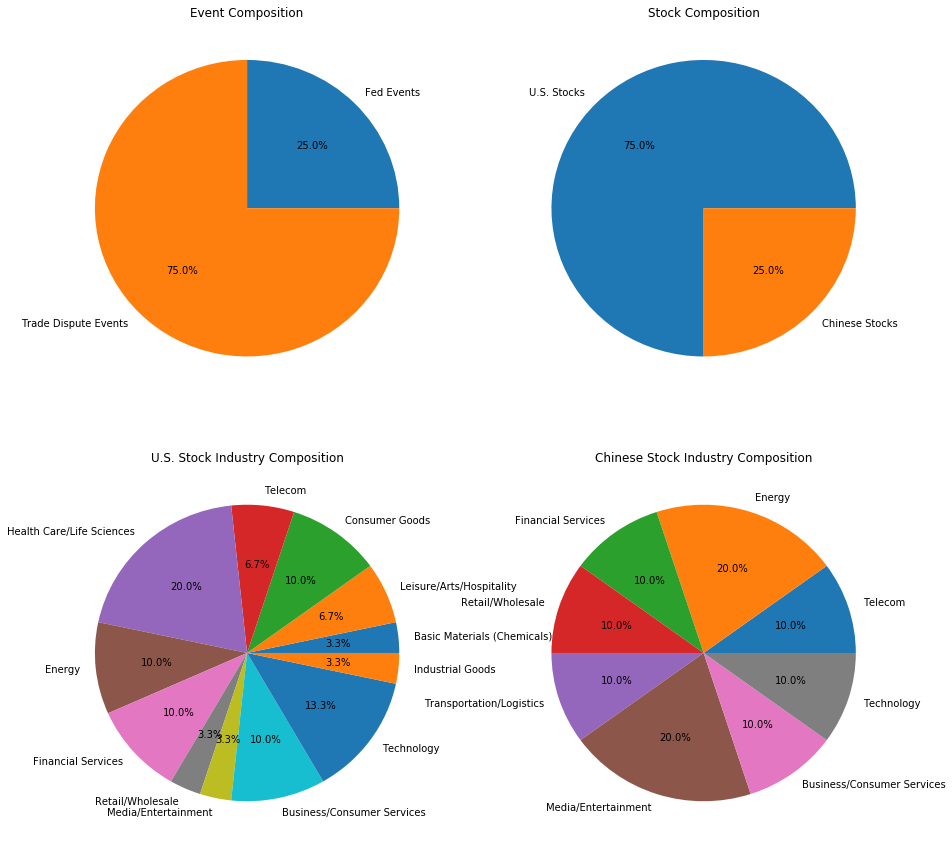

In [64]:
# plot event, stock, and industry compositions
# fig = plt.figure()

plt.figure(1)
# gridspec.GridSpec(3,3)
plt.subplots(2,2,figsize=(15,15))

# plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
plt.subplot(221)
plt.pie([num_fed_events, num_trade_events], labels = event_cat_label, autopct = '%1.1f%%')
plt.title('Event Composition')

plt.subplot(222)
plt.pie([num_us_stock, num_china_stock], labels = ['U.S. Stocks', 'Chinese Stocks'], autopct = '%1.1f%%')
plt.title('Stock Composition')

plt.subplot(223)
plt.pie(us_unique_industry_count_pct,labels = us_unique_industry_list, autopct = '%1.1f%%')
plt.title('U.S. Stock Industry Composition')

plt.subplot(224)
plt.pie(china_unique_industry_count_pct, labels= china_unique_industry_list, autopct = '%1.1f%%')
plt.title('Chinese Stock Industry Composition')

plt.show()

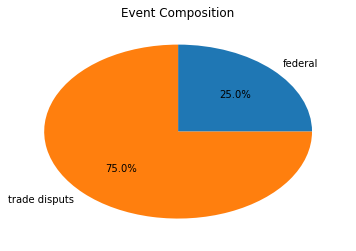

In [50]:
num_fed_events = len(fed_eventdate_set)
num_trade_events = len(trade_eventdate_set)
labels = ['federal', 'trade disputs']
X = [num_fed_events, num_trade_events]
fig = plt.figure()
plt.pie(X, labels = labels,autopct = '%1.1f%%')
plt.title('Event Composition')
plt.show()

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot([1,2,3,4,5], [10,5,10,5,10], 'r-')

ax2 = fig.add_subplot(222)
ax2.plot([1,2,3,4], [1,4,9,16], 'k-')

ax3 = fig.add_subplot(223)
ax3.plot([1,2,3,4], [1,10,100,1000], 'b-')

ax4 = fig.add_subplot(224)
ax4.plot([1,2,3,4], [0,0,1,1], 'g-')

In [50]:


dataframe = pd.DataFrame(pd.read_csv('/Users/sheng/Documents/Jupyter Notebook/Tools for Analytics/Fall 2018/Fed events v3.csv'))
event_name = dataframe['Event']
company = dataframe['Ticker']
company_name = dataframe['Company Name']
market = dataframe['Market'] #240
industry = dataframe['Industry']
year = dataframe['Year']
month = dataframe['Month']
day = dataframe['Day']

# match stock with market (either DJI or NASDAQ)
dic = {}
for i in range(0, len(market)):
    dic[company[i]] = market[i]

#Add an "EventDate" column to the main dataframe
eventdate = []
for i in range(0, len(dataframe)):
    eventdate.append(datetime.datetime(year[i], month[i], day[i]))
dataframe['EventDate'] = eventdate

inter_days = []
uniquedays = sorted(dataframe['EventDate'].unique()) # 8 unique days
for i in range(0, len(uniquedays)-1):
    inter_days.append(int((uniquedays[i+1] - uniquedays[i])/np.timedelta64(1,'D')))
sample_length = min(inter_days) # 84, inter_days:  [364, 91, 91, 182, 98, 84, 105]


#### Regression #####

reg_result= []

# inter_days
eventdate_set = dataframe['EventDate'].unique()
subdate_cumulative_abnormal_return = pd.DataFrame()

for date in eventdate_set:
    subevent_df = dataframe[dataframe.EventDate == date]
    start_date = date - np.timedelta64(sample_length, 'D')
    end_date = date + np.timedelta64(sample_length, 'D')
    
    subevent_company_list = subevent_df['Ticker'].unique()
    subevent_cumulative_abnormal_return = pd.DataFrame() # again?

    for company in subevent_company_list:
        price = web.DataReader([company, dic[company]],'yahoo', start_date,end_date)
        close_price = price['Close']
        return_rate = close_price.pct_change()
        x =return_rate[company]
        X= sm.add_constant(x)
        y = return_rate[dic[company]]
        model = sm.OLS(y,X,missing='drop')
        result = model.fit()
        (a,b) = result.params
        return_rate['Abnormal_Return'] = y - x * b - a
        subevent_cumulative_abnormal_return[f'{company}'] = return_rate['Abnormal_Return'].cumsum()[1:]
        subevent_cumulative_abnormal_return
    
    subevent_cumulative_abnormal_return['Average_CAR'] = subevent_cumulative_abnormal_return.apply(lambda x: x.sum()/(len(subevent_company_list)),axis = 1)
    reg_result.append(subevent_cumulative_abnormal_return['Average_CAR'])

### inputs for plotting
num_fed_events = len(eventdate_set) #8
num_us_stock = len(industry)/num_fed_events #30
fed_event_list = list(event_name[[0 + x*(len(dataframe)-0)/len(eventdate_set) for x in range(len(eventdate_set))]])
us_industry_list = list(industry)[0:int(num_us_stock)]
us_unique_industry_list = list(set(us_industry_list))
us_unique_industry_count = list(np.unique(us_industry_list, return_counts=True)[1])
us_stock_list = list(company)[0:int(num_us_stock)]
us_company_list = list(dataframe['Company Name'])[0:int(num_us_stock)]



,DWDP,MMM,IBM,XOM,CVX,PG,NKE,KO,AXP,V,...,DIS,HD,WBA,WMT,INTC,MSFT,CSCO,AAPL,VZ,Average_CAR
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-06,3.950931e-03,3.593444e-03,7.918062e-04,3.326645e-03,2.999182e-03,3.683656e-03,3.947677e-03,4.240523e-03,4.377294e-03,1.358798e-03,...,6.397082e-03,3.144935e-03,7.739300e-03,4.267421e-03,2.582435e-04,5.307715e-03,1.228940e-02,6.555786e-03,3.317773e-03,3.459143e-03
2018-07-09,1.157585e-02,8.903845e-03,8.613484e-03,1.211068e-02,9.881210e-03,1.965790e-02,1.216347e-02,1.939801e-02,1.000196e-02,9.736859e-03,...,1.413105e-02,1.173551e-02,1.489323e-02,1.215272e-02,1.023720e-02,1.069366e-02,2.270980e-02,8.479783e-03,1.786523e-02,1.139426e-02
2018-07-10,1.062804e-02,1.216533e-02,1.279489e-02,1.239202e-02,1.027595e-02,2.098800e-02,1.585156e-02,2.013413e-02,1.600335e-02,1.166063e-02,...,1.979200e-02,1.320287e-02,2.127708e-02,1.330889e-02,1.392033e-02,1.036266e-02,2.137365e-02,9.639542e-03,2.189292e-02,1.425674e-02
2018-07-11,9.051241e-03,1.235036e-02,2.611032e-03,9.726683e-03,1.284565e-02,1.338754e-02,7.652415e-03,1.287001e-02,5.305684e-03,-1.853942e-03,...,2.460317e-03,5.124930e-03,1.387601e-02,6.860534e-03,9.596728e-03,6.775609e-03,2.108030e-02,1.090388e-02,1.279616e-02,8.701415e-03
2018-07-12,1.749494e-02,1.719040e-02,7.411277e-03,1.753251e-02,1.907143e-02,2.285099e-02,1.615801e-02,2.297274e-02,9.999410e-03,1.673459e-03,...,1.060769e-02,1.113370e-02,2.780901e-02,1.593721e-02,1.206655e-02,7.575310e-03,2.137851e-02,1.645062e-02,2.182093e-02,1.451766e-02
2018-07-13,1.976182e-02,1.623177e-02,1.157145e-02,1.671565e-02,2.291717e-02,2.554682e-02,1.936929e-02,2.612426e-02,1.752167e-02,6.724528e-03,...,7.110818e-03,1.245210e-02,1.960993e-02,1.549714e-02,1.601115e-02,1.095505e-03,4.813594e-02,1.607567e-02,2.490716e-02,1.692144e-02
2018-07-16,2.416469e-02,1.799251e-02,1.349306e-02,2.308334e-02,2.731127e-02,2.667714e-02,1.865201e-02,2.797887e-02,1.851461e-02,1.124310e-02,...,8.024297e-03,1.302970e-02,1.887825e-02,1.745838e-02,1.837759e-02,2.728333e-03,3.594281e-02,1.476207e-02,2.597533e-02,1.753584e-02
2018-07-17,1.800996e-02,1.767754e-02,1.929064e-02,2.581442e-02,3.218253e-02,2.763390e-02,2.183657e-02,2.562922e-02,1.846670e-02,9.655074e-03,...,9.763326e-03,9.422901e-03,2.332812e-02,1.770199e-02,2.142826e-02,3.608895e-03,4.561616e-02,1.981322e-02,2.827025e-02,1.886403e-02
2018-07-18,2.281375e-02,2.031967e-02,1.922903e-02,2.891437e-02,3.590251e-02,3.124963e-02,2.918961e-02,2.988178e-02,1.199188e-02,8.800136e-03,...,1.127414e-02,1.208760e-02,2.092516e-02,2.123516e-02,2.422490e-02,9.633966e-03,4.844608e-02,2.267323e-02,3.182081e-02,2.053962e-02


In [ ]:
eventdate_set

In [90]:
num_fed_events = len(eventdate_set) #8
num_us_stock = len(industry)/num_fed_events #30
int(num_us_stock)

30

In [93]:
num_fed_events = len(eventdate_set) #8
num_us_stock = len(industry)/num_fed_events #30
# list(industry)
list(industry)[0:int(num_us_stock)]
list(dataframe['Company'])[0:int(num_us_stock)]

KeyError: 'Company'

In [99]:
list(dataframe['Company Name'])[0:int(num_us_stock)]


['DowDuPont Inc.',
 '3M Co.',
 'International Business Machines Corp.',
 'Exxon Mobil Corp.',
 'Chevron Corp.',
 'Procter & Gamble Co.',
 'Nike Inc. Cl B',
 'Coca-Cola Co.',
 'American Express Co.',
 'VISA Inc. Cl A',
 'Goldman Sachs Group Inc.',
 'UnitedHealth Group Inc.',
 'JPMorgan Chase & Co.',
 'Travelers Cos. Inc.',
 'Johnson & Johnson',
 'Merck & Co. Inc.',
 'Pfizer Inc.',
 'United Technologies Corp.',
 'Caterpillar Inc.',
 'Boeing Co.',
 "McDonald's Corp.",
 'Walt Disney Co.',
 'Home Depot Inc.',
 'Walgreens Boots Alliance Inc.',
 'Walmart Inc.',
 'Intel Corp.',
 'Microsoft Corp.',
 'Cisco Systems Inc.',
 'Apple Inc.',
 'Verizon Communications Inc.']

In [101]:
us_industry_list = list(industry)[0:int(num_us_stock)]
list(set(us_industry_list))

['Basic Materials (Chemicals)',
 'Telecom',
 'Energy',
 'Business/Consumer Services',
 'Media/Entertainment',
 'Consumer Goods',
 'Financial Services',
 'Health Care/Life Sciences',
 'Leisure/Arts/Hospitality',
 'Industrial Goods',
 'Technology',
 'Retail/Wholesale']

In [107]:
us_unique_industry_count = list(np.unique(us_industry_list, return_counts=True)[1])
us_unique_industry_list = list(set(us_industry_list))

In [118]:
us_unique_industry_count_pct = [(x*100) / 30 for x in us_unique_industry_count]
sum(us_unique_industry_count_pct)
# myList = [10,20,30,40,50,60,70,80,90]
# myInt = 10
# newList = [x / myInt for x in myList]

99.999999999999986

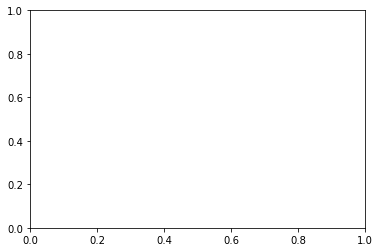

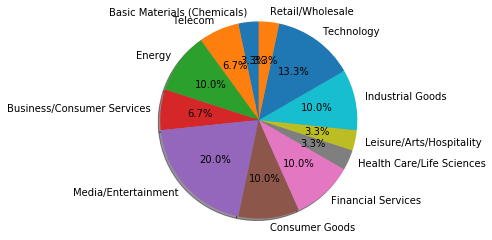

In [119]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
# sizes = [15, 30, 45, 10]
# explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(us_unique_industry_count_pct, labels=us_unique_industry_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()